# Stage 5: Speech-Tagging

### Importing Libraries

In [1]:
import pandas as pd
from tqdm import tqdm
from nltk import pos_tag, word_tokenize

### Reading Data

In [2]:
# Import data_clean_comps
df = pd.read_pickle('data_analysed.pkl')

df = df[df.comps_mention != 'na']
df.reset_index(inplace=True)

df

,index,text,rating,summary,comps_mention,polarity,pol_count,sus_mention,category,sus_category
0,0,My boyfriend bought this for our house and ou...,1,,panel,0.000000,-1,na,Technology,eneryg
1,8,Unfortunately this is not a great device I ha...,1,Unfortunately this is not a great device I hav...,panel,0.049583,1,na,Durability,material
2,13,Such a crappy microwave It has absolutely no ...,1,Such a crappy microwave It has absolutely no p...,alexa,0.124306,1,na,Power,waste
3,18,We have owned this for over a year now and th...,1,We have owned this for over a year now and the...,panel,0.050000,1,na,Technology,eneryg
4,20,Honestly Im not sure what the point is Ive ne...,2,Honestly Im not sure what the point is Ive nev...,door,0.012879,1,na,Technology,waste
...,...,...,...,...,...,...,...,...,...,...
432,3732,i did not get the alexa feature aspictured on...,3,i did not get the alexa feature aspictured on ...,alexa,0.800000,1,na,Technology,material
433,3737,Like Small SizeDislike You can not use Alexa ...,4,Like Small SizeDislike You can not use Alexa t...,door,-0.200000,-1,na,Power,waste
434,3774,Can barely handle popcorn Takes forever to he...,1,Can barely handle popcorn Takes forever to hea...,handle,0.050000,1,na,Interior,eneryg
435,3784,Love the design Especially the handle Much be...,5,Love the design Especially the handle Much bet...,handle,0.250000,1,na,Technology,eneryg


### Adjective extraction from comps_mention

In [3]:
comps_df = pd.DataFrame(df.groupby('comps_mention')['text'].apply(lambda x: "%s" % '. .'.join(x)))
comps_df.reset_index(inplace=True)

comps_df

,comps_mention,text
0,alexa,Such a crappy microwave It has absolutely no ...
1,case,The Alexa compatible microwave is impressive ...
2,door,Honestly Im not sure what the point is Ive ne...
3,fan,The Alexa capability was fun but not always a...
4,handle,You might wonder what you need a voice contro...
5,magnetron,Okay So I bought this microwave April 2020 It...
6,panel,My boyfriend bought this for our house and ou...
7,socket,Rated at 700 Watt Actual is 1 100 Watt If you...
8,turntable,Got one of these It broke in less than a year...
9,waveguide,I had this microwave for less than a year and...


In [4]:
dict = {}
# print(str(comps_df.text[1]))
for i in range(comps_df.shape[0]):
    word = [word for word, pos in pos_tag(word_tokenize(str(comps_df.text[i]))) if pos.startswith('JJ')]
    word_string = ', '.join([str(item) for item in word])
    dict[comps_df.comps_mention[i]] = word_string


dict = pd.DataFrame.from_dict(dict, orient='index', columns={'adj'})
dict.reset_index(inplace=True)

comps_df['adj'] = dict['adj']

comps_df

,comps_mention,text,adj
0,alexa,Such a crappy microwave It has absolutely no ...,"Such, crappy, fine, alexa, cool, cool, able, g..."
1,case,The Alexa compatible microwave is impressive ...,"compatible, impressive, correct, such, remote,..."
2,door,Honestly Im not sure what the point is Ive ne...,"sure, able, long, useful, stupid, more, Other,..."
3,fan,The Alexa capability was fun but not always a...,"active, fine, easy, last, mechanical, inner, c..."
4,handle,You might wonder what you need a voice contro...,"once, there, couple, pretty, lackluster, i, an..."
5,magnetron,Okay So I bought this microwave April 2020 It...,bad
6,panel,My boyfriend bought this for our house and ou...,"first, tiny, small, easy, first, cool, terribl..."
7,socket,Rated at 700 Watt Actual is 1 100 Watt If you...,"longet, due"
8,turntable,Got one of these It broke in less than a year...,"less, same, Every, turntable, turntable, table..."
9,waveguide,I had this microwave for less than a year and...,"less, past, little, generic, familiar, other, ..."


In [5]:
# Converting it to Document-Term Matrix 
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(comps_df.adj)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names_out())
data_dtm.index = comps_df.index
data_dtm

# Transpose the data for wordcloud generation
wc_data = data_dtm.transpose()

wc_data

,0,1,2,3,4,5,6,7,8,9
able,4,0,7,0,0,0,3,0,2,0
abrir,1,0,0,0,0,0,0,0,0,0
active,0,0,1,1,0,0,0,0,0,0
actual,3,0,0,0,0,0,0,0,0,0
acumulate,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
wrong,0,1,2,0,0,0,0,0,1,0
youd,1,0,0,0,0,0,0,0,0,0
young,0,0,2,0,0,0,0,0,0,0
youve,0,0,0,0,0,0,1,0,0,0


In [6]:
# Find the top 30 words said in each comps_mention
top_dict = {}
for c in wc_data.columns:
    top = wc_data[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

top_dict

{0: [('alexa', 59),
  ('small', 40),
  ('great', 32),
  ('easy', 17),
  ('good', 13),
  ('little', 10),
  ('echo', 9),
  ('perfect', 8),
  ('old', 8),
  ('nice', 8),
  ('smaller', 8),
  ('cool', 8),
  ('compact', 6),
  ('terrible', 5),
  ('cheap', 5),
  ('bigger', 5),
  ('fine', 5),
  ('simple', 5),
  ('longer', 5),
  ('basic', 4),
  ('decent', 4),
  ('happy', 4),
  ('handy', 4),
  ('able', 4),
  ('sure', 3),
  ('microwave', 3),
  ('bad', 3),
  ('actual', 3),
  ('easier', 3),
  ('useful', 3)],
 1: [('good', 5),
  ('small', 5),
  ('great', 4),
  ('cool', 3),
  ('easy', 3),
  ('microwave', 3),
  ('fine', 2),
  ('longer', 2),
  ('basic', 2),
  ('better', 2),
  ('disposable', 1),
  ('fantastic', 1),
  ('excellent', 1),
  ('sleep', 1),
  ('loud', 1),
  ('mishap', 1),
  ('long', 1),
  ('safe', 1),
  ('dirty', 1),
  ('sudden', 1),
  ('super', 1),
  ('dangerous', 1),
  ('cringy', 1),
  ('correct', 1),
  ('minimal', 1),
  ('compatible', 1),
  ('stick', 1),
  ('right', 1),
  ('local', 1),
  ('re

In [7]:
# Print the top 15 words said in each ratings
for category, top_words in top_dict.items():
    print(category)
    print(', '.join([word for word, count in top_words[0:15]]))
    print('---')

0
alexa, small, great, easy, good, little, echo, perfect, old, nice, smaller, cool, compact, terrible, cheap
---
1
good, small, great, cool, easy, microwave, fine, longer, basic, better, disposable, fantastic, excellent, sleep, loud
---
2
great, open, small, good, little, better, able, loud, long, perfect, bigger, new, nice, fine, regular
---
3
small, great, basic, fantastic, fancy, little, easy, hot, perfect, usual, big, good, right, kitchen, powerful
---
4
small, popcorn, great, easy, smaller, good, larger, lackluster, frozen, incorrect, incredible, kick, excellent, big, decent
---
5
bad, able, purpose, prudent, protective, proper, prone, pro, previous, pretty, powerful, possible, popped, popcorn, pop
---
6
small, great, inside, little, right, similar, disappointed, defective, loud, old, bad, disappointing, able, big, aware
---
7
longet, able, pointless, prudent, protective, proper, prone, pro, previous, pretty, powerful, possible, popped, popcorn, pop
---
8
turntable, small, great, 

In [8]:
from sklearn.feature_extraction import text 

# add_stop_words = ['microwave']

# Add new stop words
stop_words = text.ENGLISH_STOP_WORDS

In [9]:
# Let's make some word clouds!
from wordcloud import WordCloud
from PIL import Image
import numpy as np

mask = np.array(Image.open('AmazonMicrowave.jpg'))

wc = WordCloud(stopwords=stop_words, mask=mask, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

In [10]:
name = list(comps_df['comps_mention'])

### Wordcloud generated from comps_mention

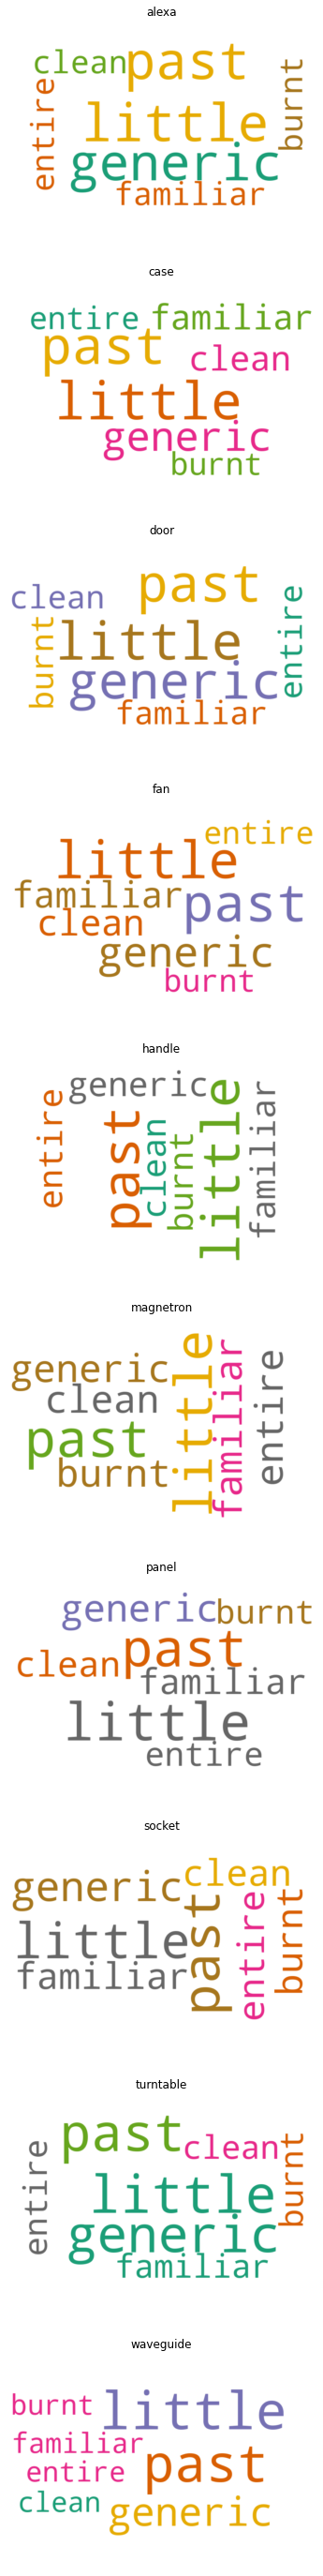

In [11]:
# Reset the output dimensions
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [100, 50]


# Create subplots for each comedian
for index, rating in enumerate(wc_data.columns):
    wc.generate(comps_df.adj[category])
    
    plt.subplot(len(name), 1, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(name[index])
    
plt.show()

### Adjective extraction from sus_category

In [12]:
sus_df = pd.DataFrame(df.groupby('sus_category')['text'].apply(lambda x: "%s" % '. .'.join(x)))
sus_df.reset_index(inplace=True)

sus_df

,sus_category,text
0,eneryg,My boyfriend bought this for our house and ou...
1,environmental,Got one of these It broke in less than a year...
2,material,Unfortunately this is not a great device I ha...
3,waste,Such a crappy microwave It has absolutely no ...


In [13]:
dict = {}

for i in range(sus_df.shape[0]):
    word = [word for word, pos in pos_tag(word_tokenize(str(sus_df.text[i]))) if pos.startswith('JJ')]
    word_string = ', '.join([str(item) for item in word])
    dict[sus_df.sus_category[i]] = word_string


dict = pd.DataFrame.from_dict(dict, orient='index', columns={'adj'})
dict.reset_index(inplace=True)

sus_df['adj'] = dict['adj']

sus_df

,sus_category,text,adj
0,eneryg,My boyfriend bought this for our house and ou...,"first, tiny, small, easy, first, cool, terribl..."
1,environmental,Got one of these It broke in less than a year...,"less, same, Every, turntable, turntable, table..."
2,material,Unfortunately this is not a great device I ha...,"great, flat, great, little, microwaveable, par..."
3,waste,Such a crappy microwave It has absolutely no ...,"Such, crappy, fine, alexa, cool, cool, able, g..."


In [14]:
# Converting it to Document-Term Matrix 
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(sus_df.adj)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names_out())
data_dtm.index = sus_df.index
data_dtm

# Transpose the data for wordcloud generation
wc_data = data_dtm.transpose()

wc_data

,0,1,2,3
able,10,0,3,3
abrir,1,0,0,0
active,0,0,2,0
actual,2,0,0,1
acumulate,1,0,0,0
...,...,...,...,...
wrong,3,0,1,0
youd,0,0,0,1
young,1,0,1,0
youve,0,0,1,0


In [15]:
# Find the top 30 words said in each comps_mention
top_dict = {}
for c in wc_data.columns:
    top = wc_data[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

top_dict

{0: [('small', 66),
  ('great', 61),
  ('alexa', 39),
  ('good', 30),
  ('turntable', 27),
  ('easy', 24),
  ('little', 23),
  ('perfect', 15),
  ('open', 14),
  ('bad', 13),
  ('old', 13),
  ('smaller', 11),
  ('nice', 11),
  ('microwave', 11),
  ('able', 10),
  ('cool', 9),
  ('sure', 9),
  ('longer', 9),
  ('bigger', 9),
  ('fine', 9),
  ('better', 9),
  ('basic', 8),
  ('terrible', 8),
  ('right', 8),
  ('larger', 8),
  ('compact', 7),
  ('inside', 7),
  ('fantastic', 7),
  ('new', 7),
  ('echo', 7)],
 1: [('turntable', 2),
  ('easy', 1),
  ('included', 1),
  ('table', 1),
  ('able', 0),
  ('pointless', 0),
  ('protective', 0),
  ('proper', 0),
  ('prone', 0),
  ('previous', 0),
  ('pretty', 0),
  ('powerful', 0),
  ('possible', 0),
  ('popped', 0),
  ('popcorn', 0),
  ('pop', 0),
  ('plastic', 0),
  ('pleased', 0),
  ('pull', 0),
  ('pictured', 0),
  ('personal', 0),
  ('perfect', 0),
  ('patient', 0),
  ('past', 0),
  ('particular', 0),
  ('partial', 0),
  ('paired', 0),
  ('pain

In [16]:
# Print the top 15 words said in each ratings
for category, top_words in top_dict.items():
    print(category)
    print(', '.join([word for word, count in top_words[0:15]]))
    print('---')

0
small, great, alexa, good, turntable, easy, little, perfect, open, bad, old, smaller, nice, microwave, able
---
1
turntable, easy, included, table, able, pointless, protective, proper, prone, previous, pretty, powerful, possible, popped, popcorn
---
2
great, small, alexa, little, good, basic, easy, inside, big, fine, nice, turntable, old, right, loud
---
3
small, alexa, turntable, useless, great, popcorn, fine, terrible, cool, better, able, extra, complete, ready, pointless
---


In [17]:
from sklearn.feature_extraction import text 

# add_stop_words = ['microwave']

# Add new stop words
stop_words = text.ENGLISH_STOP_WORDS

### Wordcloud generated from sus_category

In [18]:
# Let's make some word clouds!
from wordcloud import WordCloud
from PIL import Image
import numpy as np

mask = np.array(Image.open('AmazonMicrowave.jpg'))

wc = WordCloud(stopwords=stop_words, mask=mask, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

In [19]:
name = list(sus_df['sus_category'])

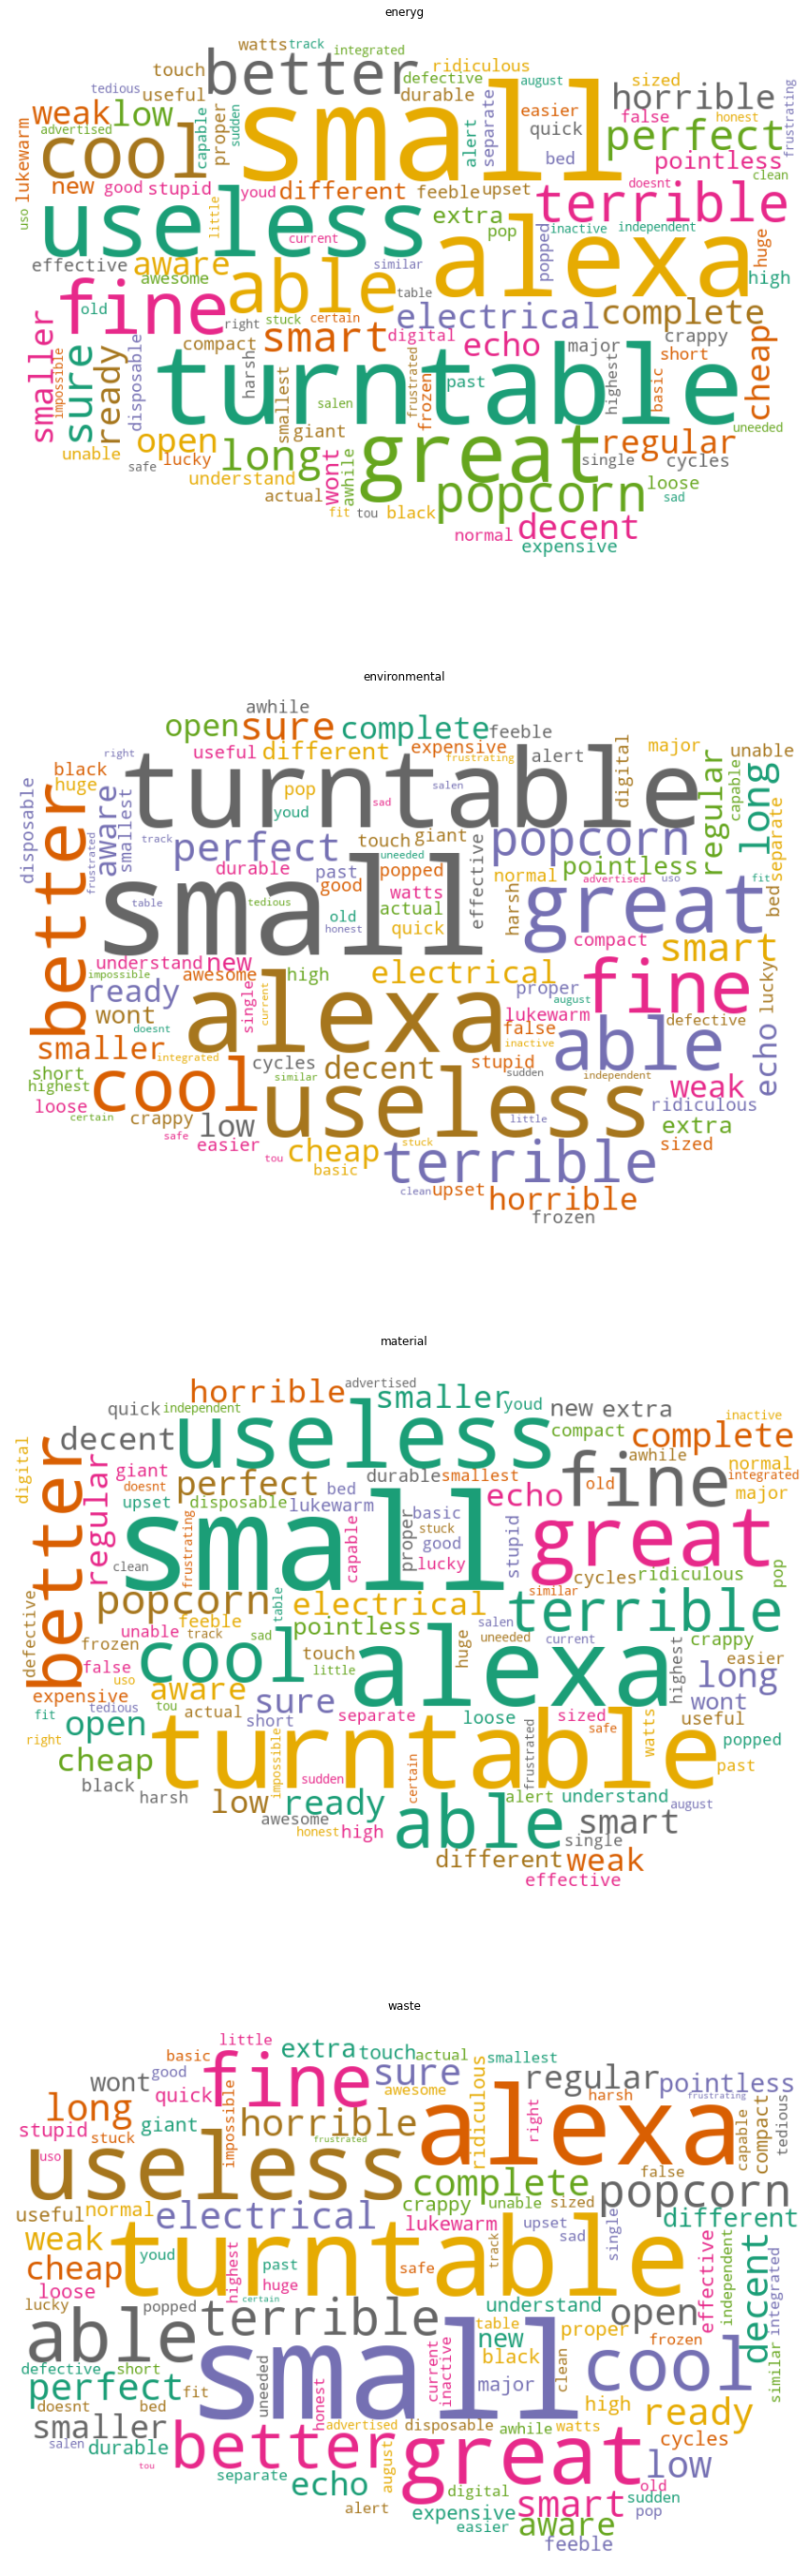

In [20]:
# Reset the output dimensions
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [100, 50]


# Create subplots for each comedian
for index, rating in enumerate(wc_data.columns):
    wc.generate(sus_df.adj[category])
    
    plt.subplot(len(name), 1, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(name[index])
    
plt.show()

### Adjective extraction from sus_mentioned
- Focus on waste

In [21]:
sus_df = pd.DataFrame(df.groupby('sus_mention')['text'].apply(lambda x: "%s" % '. .'.join(x)))
sus_df = sus_df[1:]
sus_df.reset_index(inplace=True)


sus_df

,sus_mention,text
0,waste,we do not have a smart home and the fact that...


In [22]:
dict = {}

for i in range(sus_df.shape[0]):
    word = [word for word, pos in pos_tag(word_tokenize(str(sus_df.text[i]))) if pos.startswith('JJ')]
    word_string = ', '.join([str(item) for item in word])
    dict[sus_df.sus_mention[i]] = word_string


dict = pd.DataFrame.from_dict(dict, orient='index', columns={'adj'})
dict.reset_index(inplace=True)

sus_df['adj'] = dict['adj']

sus_df

,sus_mention,text,adj
0,waste,we do not have a smart home and the fact that...,"smart, major, complete, ridiculous, ten, black..."


In [23]:
# Converting it to Document-Term Matrix 
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(sus_df.adj)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names_out())
data_dtm.index = sus_df.index
data_dtm

# Transpose the data for wordcloud generation
wc_data = data_dtm.transpose()

wc_data

,0
actual,1
alert,1
alexa,1
aware,1
black,1
certain,1
cheap,1
complete,1
current,1
decent,2


In [24]:
# Find the top 30 words said in each sus_mention
top_dict = {}
for c in wc_data.columns:
    top = wc_data[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

top_dict

{0: [('small', 2),
  ('decent', 2),
  ('actual', 1),
  ('little', 1),
  ('tou', 1),
  ('sudden', 1),
  ('smart', 1),
  ('sized', 1),
  ('safe', 1),
  ('ridiculous', 1),
  ('new', 1),
  ('major', 1),
  ('great', 1),
  ('alert', 1),
  ('electrical', 1),
  ('current', 1),
  ('complete', 1),
  ('cheap', 1),
  ('certain', 1),
  ('black', 1),
  ('aware', 1),
  ('alexa', 1),
  ('useless', 1)]}

In [25]:
# Print the top 15 words
for category, top_words in top_dict.items():
    print(category)
    print(', '.join([word for word, count in top_words[0:15]]))
    print('---')

0
small, decent, actual, little, tou, sudden, smart, sized, safe, ridiculous, new, major, great, alert, electrical
---


In [26]:
from sklearn.feature_extraction import text 

add_stop_words = ['tou']

# Add new stop words
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

### Wordcloud generated from sus_category

In [27]:
# Let's make some word clouds!
from wordcloud import WordCloud
from PIL import Image
import numpy as np

mask = np.array(Image.open('AmazonMicrowave.jpg'))

wc = WordCloud(stopwords=stop_words, mask=mask, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

In [28]:
name = list(sus_df['sus_mention'])

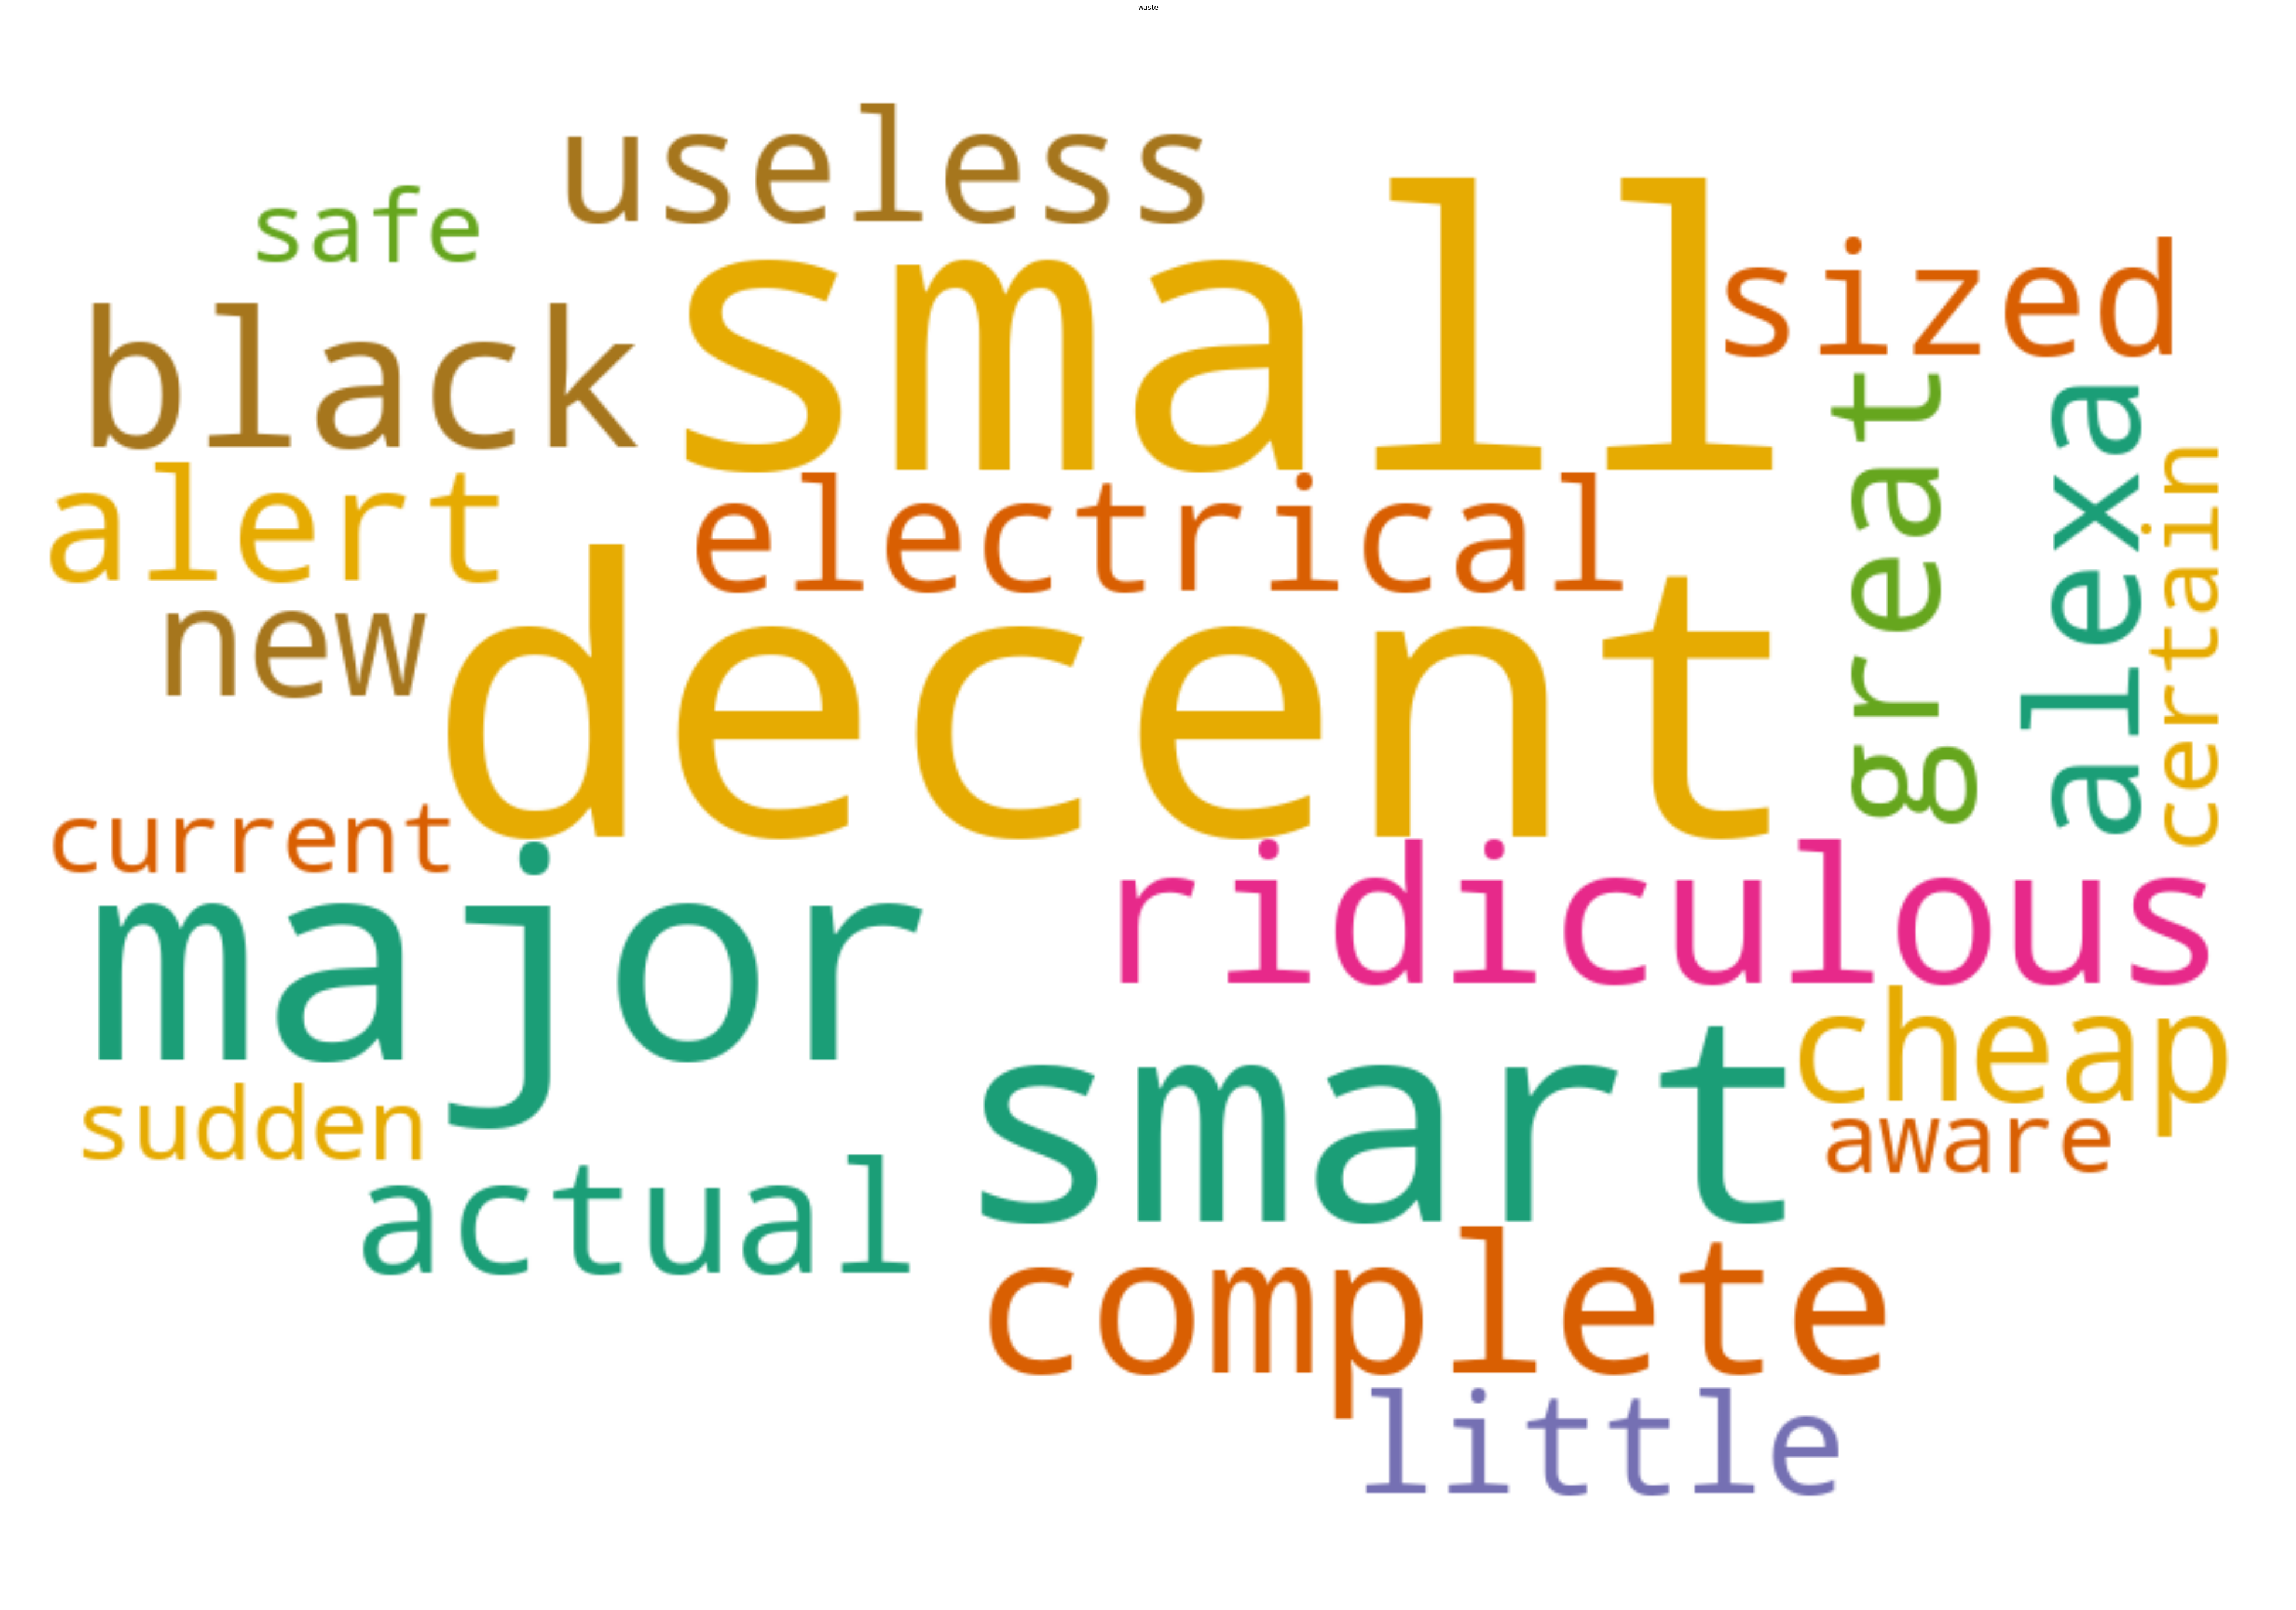

In [29]:
# Reset the output dimensions
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [100, 50]


# Create subplots for each comedian
for index, rating in enumerate(wc_data.columns):
    wc.generate(sus_df.adj[category])
    
    plt.subplot(len(name), 1, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(name[index])
    
plt.show()